# Hands on Computer Vision Exercise Notebook

## General Setup

Make sure selected kernel for the notebook is "venv"

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### Exercise 2: Computer Images and Processing

In [2]:
# Load and display test image

# open test image
dog_raw = cv2.imread('../data/dog.jpg')  # default: bgr for display
print(f"arr1 shape (H x W x Channels) or (Rows x Cols x Channels): {dog_raw.shape}")

arr1 shape (H x W x Channels) or (Rows x Cols x Channels): (576, 768, 3)


In [3]:
print(dog_raw)

[[[ 50  58  57]
  [ 51  59  58]
  [ 53  61  60]
  ...
  [ 47  89 142]
  [ 41  50  88]
  [ 47  71  63]]

 [[ 51  59  58]
  [ 51  59  58]
  [ 52  60  59]
  ...
  [ 37  74 124]
  [ 41  50  84]
  [ 46  70  58]]

 [[ 51  59  58]
  [ 51  59  58]
  [ 52  60  59]
  ...
  [ 25  54  98]
  [ 48  54  77]
  [ 43  62  45]]

 ...

 [[179 168 160]
  [179 168 160]
  [182 171 163]
  ...
  [ 64  64  80]
  [ 36  39  53]
  [ 48  53  62]]

 [[180 169 161]
  [179 168 160]
  [175 164 156]
  ...
  [ 61  61  79]
  [ 37  40  54]
  [ 52  56  67]]

 [[176 165 157]
  [178 167 159]
  [172 161 153]
  ...
  [ 62  62  80]
  [ 33  36  50]
  [ 35  39  50]]]


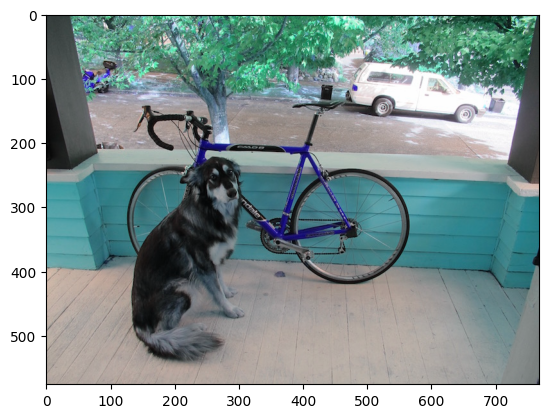

In [4]:
plt.imshow(dog_raw)
plt.show()

It looks a little...blue?

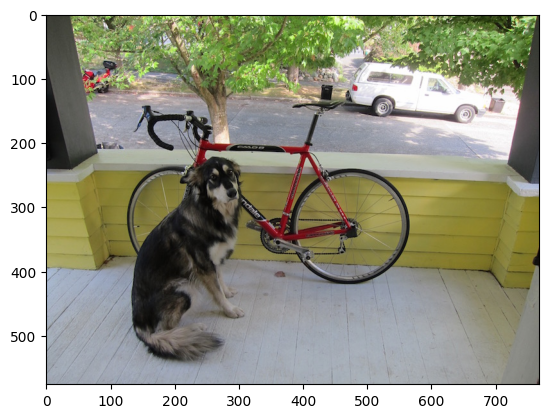

In [5]:
# Use openCV to reverse channel order
plt.imshow(cv2.cvtColor(dog_raw, cv2.COLOR_BGR2RGB))
plt.show()

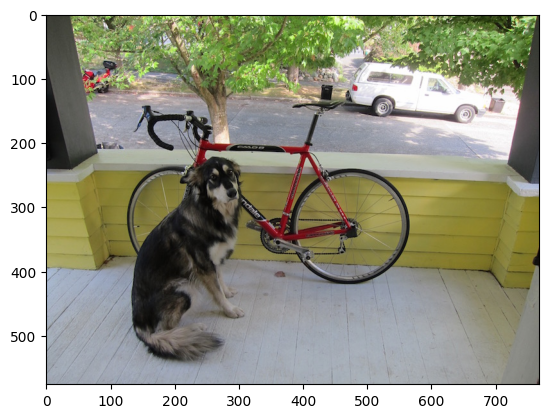

In [6]:
# Convert channels a different way
dog = dog_raw[..., ::-1]                  # bgr -> rgb for inference
plt.imshow(dog)
plt.show()

Manipulating the image is achieved by manipulating the array!

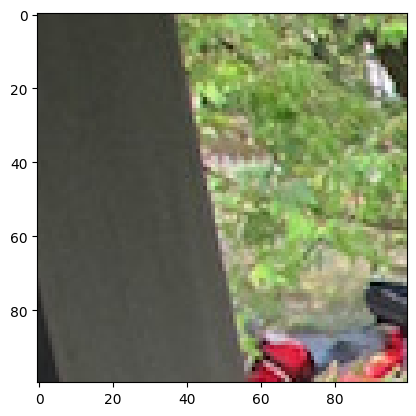

In [7]:
# cropping the image is a simple as indexing the array
cropped = dog[:100,:100,:]
plt.imshow(cropped)
plt.show()

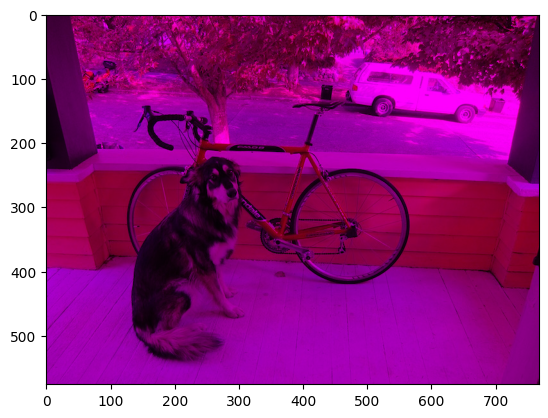

In [8]:
# edit color channels
# Channel order: RGB
no_green = dog.copy()
no_green[:,:,1] = 0

plt.imshow(no_green)
plt.show()

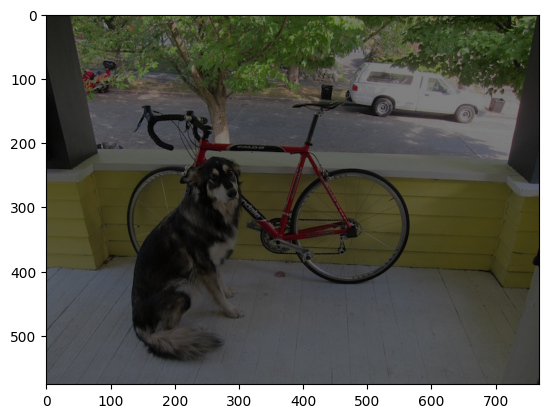

In [9]:
# dimming is a matter of division!
dimmed = (dog.copy() / 2).astype(int)

plt.imshow(dimmed)
plt.show()

In [10]:
# inspect the first 20 elements of the first row of each image's Green channel
print(dimmed[0,:20,1])
print(dog[0,:20,1])

[29 29 30 31 31 31 29 29 28 29 30 30 29 29 29 29 29 30 31 30]
[58 59 61 62 63 62 59 58 57 58 60 60 59 58 58 58 59 60 62 61]


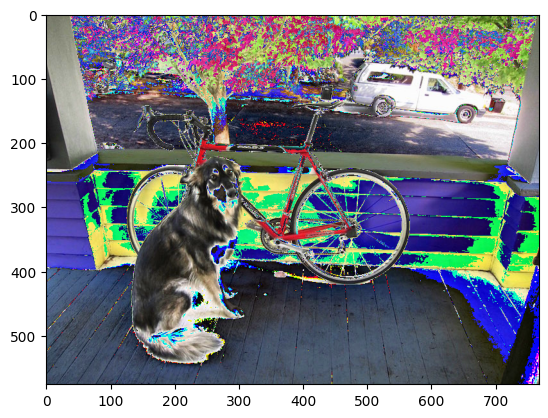

In [11]:
# What if we multiply?
doubled = (dog.copy() * 2).astype(int)

plt.imshow(doubled)
plt.show()

In [12]:
# huh? Some are brighter but some are dimmer
# inspect the 200-215th elements of the first row of each image's Green channel
print(dog[0,:15,1])
print(doubled[0,:15,1])


[58 59 61 62 63 62 59 58 57 58 60 60 59 58 58]
[116 118 122 124 126 124 118 116 114 116 120 120 118 116 116]


In [13]:
# inspect the 200-215th elements of the first row of each image's Green channel
print(dog[0,200:215,1])
print(doubled[0,200:215,1])

[188 204 240 236 224 224 218 203 186 231 249 218 184 192 161]
[120 152 224 216 192 192 180 150 116 206 242 180 112 128  66]


In [14]:
original = np.array([188, 204, 240, 236, 224, 224, 218, 203, 186, 231])
doubled_for_real = original * 2
double_modulo = (original * 2) % 256
print(original)
print(doubled_for_real)
print(double_modulo)

[188 204 240 236 224 224 218 203 186 231]
[376 408 480 472 448 448 436 406 372 462]
[120 152 224 216 192 192 180 150 116 206]


In [15]:
# can't represent values over 255, so instead we're seeing (arr1 * 2) modulo 256
# how does the computer know to do this atuomatically??

In [16]:
print(dog.dtype)
print(original.dtype)

uint8
int64


The answer is the data type! The datatype of `arr2` is 'uint8' which stands for "unsigned 8-bit integer". When we initially read in this image to the variable `arr1` with the code `arr1 = cv2.imread('../data/dog.jpg')`, it was automatically encoded as 'uint8'.  This data type represents integers with 8 binary digits (bits). It ranges from 00000000 to 11111111 (which in decimal is 255). In other words this data type is only expressive enough to represent intergers in the range [0,255]. Furthermore if an operation results in a value greater than 255, than uint8 will "wrap around" using modulo arithmetic as we observed.

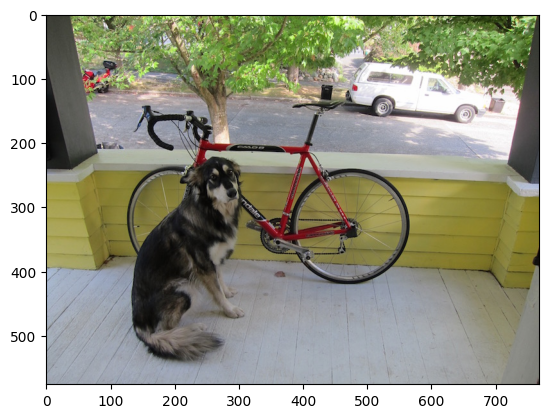

In [17]:
# Maybe instruct them to play around with the image here
plt.imshow(dog)
plt.show()

#mini challenges/ exercises
# can you think of an image transformation, and then implement it

Computer vision models require their inputs to be in very specific formats. Often it is neccesary to modify an image to meet these input specifications. For example, the model we'll be using today (tiny-yolov3) requires it's input image array values all to be scaled to the range [0,1] and have the dimensions (1x3x416x416)

https://github.com/onnx/models/tree/main/validated/vision/object_detection_segmentation/tiny-yolov3

In [18]:
# letterbox procedure
def letterbox(src, dest_shape):
    ## INPUTS ##
        #  '''resize image with unchanged aspect ratio using padding'''
        # src - an image array
        # dest_shape - tuple specifying desired letterboxed image dimensions
    ## Output ##
        # dest - letterboxed image array
    
    # get src dims
    src_width = src.shape[1]    # img.shape returns tuple (rows, cols, chan)
    src_height = src.shape[0]   # NOTE: rows => height; cols => width

    # cons dest array (filled with gray), get dest dims
    # NOTE: each 32-bit [B, G, R, A] pixel value is [128, 128, 128, 255]
    dest = np.full(dest_shape, np.uint8(128))
    if dest_shape[2] > 3:
        dest[:, :, 3] = np.uint8(255)
    dest_width = dest.shape[1]
    dest_height = dest.shape[0]

    # calculate width and height ratios
    width_ratio = dest_width / src_width        # NOTE: ratios are float values
    height_ratio = dest_height / src_height

    # init resized image width and height with max values (dest dims)
    rsz_width = dest_width
    rsz_height = dest_height

    # smallest scale factor will scale other dimension as well
    if width_ratio < height_ratio:
        rsz_height = int(src_height * width_ratio)  # NOTE: integer truncation
    else:
        rsz_width = int(src_width * height_ratio)

    # resize the image data using bi-linear interpolation
    rsz_dims = (rsz_width, rsz_height)
    rsz = cv2.resize(src, rsz_dims, 0, 0, cv2.INTER_LINEAR)

    # embed rsz into the center of dest
    dx = int((dest_width - rsz_width) / 2)          # NOTE: integer truncation
    dy = int((dest_height - rsz_height) / 2)
    dest[dy:dy+rsz_height, dx:dx+rsz_width, :] = rsz
    rsz_origin = (dx, dy)

    # letterboxing complete, return dest
    return (dest, rsz_origin, rsz_dims)

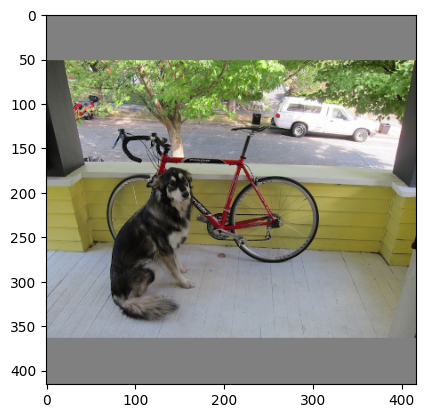

In [19]:
# letterbox the image to resize for NN input (size: (height, width, chan))
letterboxed_dog = letterbox(dog, (416, 416, 3))[0]
plt.imshow(letterboxed_dog)
plt.show()

In [20]:
dog

array([[[ 57,  58,  50],
        [ 58,  59,  51],
        [ 60,  61,  53],
        ...,
        [142,  89,  47],
        [ 88,  50,  41],
        [ 63,  71,  47]],

       [[ 58,  59,  51],
        [ 58,  59,  51],
        [ 59,  60,  52],
        ...,
        [124,  74,  37],
        [ 84,  50,  41],
        [ 58,  70,  46]],

       [[ 58,  59,  51],
        [ 58,  59,  51],
        [ 59,  60,  52],
        ...,
        [ 98,  54,  25],
        [ 77,  54,  48],
        [ 45,  62,  43]],

       ...,

       [[160, 168, 179],
        [160, 168, 179],
        [163, 171, 182],
        ...,
        [ 80,  64,  64],
        [ 53,  39,  36],
        [ 62,  53,  48]],

       [[161, 169, 180],
        [160, 168, 179],
        [156, 164, 175],
        ...,
        [ 79,  61,  61],
        [ 54,  40,  37],
        [ 67,  56,  52]],

       [[157, 165, 176],
        [159, 167, 178],
        [153, 161, 172],
        ...,
        [ 80,  62,  62],
        [ 50,  36,  33],
        [ 50,  39,  35]]

In [21]:
# pack_buffer procedure, ONNX model expects normalized float32 NCHW tensor
def pack_buffer(src):
    dest = np.array(src, dtype='float32')       # cons dest array via copy
    if dest.shape[2] > 3:
        dest = dest[:,:,:3]                     # if there is an alpha channel, remove it
    #dest = dest [..., ::-1]                     # reorder channels BGR -> RGB
    dest /= 255.0                               # normalize vals
    dest = np.transpose(dest, [2, 0, 1])        # make channel first dim
    dest = np.expand_dims(dest, 0)              # ins batch dim before chan dim
    return dest

In [22]:
dog.shape

(576, 768, 3)

In [23]:
buffered_dog = pack_buffer(dog)
buffered_dog.shape

(1, 3, 576, 768)

In [24]:
# Note that the values are no longer integers
buffered_dog

array([[[[0.22352941, 0.22745098, 0.23529412, ..., 0.5568628 ,
          0.34509805, 0.24705882],
         [0.22745098, 0.22745098, 0.23137255, ..., 0.4862745 ,
          0.32941177, 0.22745098],
         [0.22745098, 0.22745098, 0.23137255, ..., 0.38431373,
          0.3019608 , 0.1764706 ],
         ...,
         [0.627451  , 0.627451  , 0.6392157 , ..., 0.3137255 ,
          0.20784314, 0.24313726],
         [0.6313726 , 0.627451  , 0.6117647 , ..., 0.30980393,
          0.21176471, 0.2627451 ],
         [0.6156863 , 0.62352943, 0.6       , ..., 0.3137255 ,
          0.19607843, 0.19607843]],

        [[0.22745098, 0.23137255, 0.23921569, ..., 0.34901962,
          0.19607843, 0.2784314 ],
         [0.23137255, 0.23137255, 0.23529412, ..., 0.2901961 ,
          0.19607843, 0.27450982],
         [0.23137255, 0.23137255, 0.23529412, ..., 0.21176471,
          0.21176471, 0.24313726],
         ...,
         [0.65882355, 0.65882355, 0.67058825, ..., 0.2509804 ,
          0.15294118, 0.2

In [25]:
buffered_dog.dtype

dtype('float32')

"Float" or floating-point numbers are used to represent real numbers (as opposed to integers--think: fractions and decimals). "32" refers to the number of bits allocated to store each floating-point number. 32 bits = 4 bytes.  
Representing floating point numbers with a fixed number of bits entails a tradeoff between the range of values you can represent and their precision.  
TODO: briefly talk about how floating point numbers are stored (sign, exponent, significand/mantissa)

### Exercise 4: Pre-Trained Neural Nets

4. Pre-Trained Neural Networks (PTNNs)
    a.	PTNNs have architecture and trained weights.  
    b.	Getting trained Tiny YOLOv3 from ONNX model zoo  
    c.	Consider NETRON model viewer (https://github.com/lutzroeder/netron)  
    d.	onnx2torch module  
    e.	Loading ONNX model into pytorch  
    f.	Run on a test image look at output: bbox center and extent, objectness, classifications.  


In [ ]:
import onnx
import onnxruntime as ort

In [ ]:
# Read the model classes
def read_model_classes(pathname = '../model/coco.names'):
    file = open(pathname, 'r')
    classes = []
    while True:
        class_name = file.readline().strip()
        if not class_name:
            break
        classes.append(class_name)
    file.close()
    return classes

def run_inference(model, image_array):
    # cons input for ONNX model inference (packed images and their orig dims)
    img = pack_buffer(image_array)
    # dim4 = np.array([image_array.shape[1], image_array.shape[0]], dtype=np.float32).reshape(1, 2)

    # run ONNX model inference on input buffer to get results
    return model.run(None, {'input_1': img })#,'image_shape': dim4})

In [ ]:
coco_names = read_model_classes()
for item in coco_names:
    print(item)

In [ ]:
# cons ONNX Tiny YOLOv3 NN model
model   = ort.InferenceSession('../model/modified_yolov3-tiny.onnx')
# model = ort.InferenceSession('../model/yolov3-tiny.onnx')

In [ ]:
dog_results1 = run_inference(model, letterboxed_dog)

In [ ]:
# Let's take a look at our results!
dog_results1

In [ ]:
print(len(dog_results1))     
print(dog_results1[0].shape)
print(dog_results1[1].shape)

In [ ]:
dog_results1

### Exercise 5: Bounding Boxes for Object Detection

In [ ]:
# draw_annos procedure (fixed ONNX anno scaling in unscale_annos proc)
def draw_annos(src, annos, classes):
    dest = np.copy(src)
    green = (0, 255, 0)
    black = (0, 0, 0)
    face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.5
    thickness = 1
    for anno in annos:
        pt1 = (anno[0][0], anno[0][1])
        pt2 = (anno[0][2], anno[0][3])
        text = f'{classes[anno[2]]}: {anno[1]:.2f}'
        (w, h), _ = cv2.getTextSize(text, face, scale, thickness)
        pt3 = (pt1[0], pt1[1] - h)
        pt4 = (pt1[0] + w, pt1[1])
        dest = cv2.rectangle(dest, pt1, pt2, green)
        dest = cv2.rectangle(dest, pt3, pt4, green, cv2.FILLED)
        dest = cv2.putText(dest, text, pt1, face, scale, black, thickness)
    return dest

# unscale_annos procedure (fixes ONNX anno scaling)
def unscale_annos(annos, dw, dh, w0, h0, w1, h1):
    res = []
    scale_w = float(w1) / float(w0)
    scale_h = float(h1) / float(h0)
    for anno in annos:
        pt1 = (int(anno[0][1]), int(anno[0][0]))   # ONNX bug! Points are
        pt2 = (int(anno[0][3]), int(anno[0][2]))   # transposed.
        pt3 = (pt1[0] - dw, pt1[1] - dh)
        pt4 = (pt2[0] - dw, pt2[1] - dh)
        pt5 = (int(float(pt3[0]) * scale_w), int(float(pt3[1]) * scale_h))
        pt6 = (int(float(pt4[0]) * scale_w), int(float(pt4[1]) * scale_h))
        arr1 = np.array([pt5[0], pt5[1], pt6[0], pt6[1]], dtype='int32')
        res.append((arr1, anno[1], anno[2]))
    return res

#+BEGIN_EXAMPLE

# sigmoid procedure
def sigmoid(x):
    return 1.0/(1.0 + math.exp(-x))

# (redefined) proc_results procedure
def proc_results(res, classes, pobj_thresh = 0.1, pcls_thresh = 0.5, orig_img_size = 416,
                 anchors = np.array([[[81,82], [135,169], [344,319]],
                                     [[10,14], [ 23, 27], [ 37, 58]]],
                                    dtype='int32')):
    dets = []
    # candidate detection layout:
    # [x, y, w, h, pobj, pcls_0, pcls_1, ..., pcls_i]
    # i: [0, num_classes)
    num_classes = len(classes)
    pcls_offset = 5                                     # offset of class probs
    num_params = pcls_offset + num_classes              # numParams per cand det
    num_yolo_blocks = anchors.shape[0]
    num_anchors = anchors.shape[1]
    assert len(res) == num_yolo_blocks
    for blk in range(num_yolo_blocks):                  # iter over yolo blocks
        height_blk = res[blk].shape[1]
        width_blk = res[blk].shape[2]
        stride_blk = orig_img_size / width_blk          # ASSUMES square image
        shape_blk = (height_blk, width_blk, num_anchors, num_params)
        dets_blk = np.reshape(res[blk], shape_blk)
        # each yolo block has an "image" where each "pixel" has a candidate
        # detection per anchor box
        for hi in range(height_blk):                    # iter over img rows
            for wi in range(width_blk):                 # iter over img cols
                for ai in range(num_anchors):           # iter over pxl anchors
                    det = dets_blk[hi][wi][ai]          # get detection
                    pobj = sigmoid(det[4])              # get objectness prob
                    if pobj > pobj_thresh:
                        x = stride_blk * (wi + sigmoid(det[0]))
                        y = stride_blk * (hi + sigmoid(det[1]))
                        w = math.exp(det[2]) * anchors[blk][ai][0]
                        h = math.exp(det[3]) * anchors[blk][ai][1]
                        for ci in range(num_classes):
                            pcls = sigmoid(det[pcls_offset + ci])
                            if pcls > pcls_thresh:
                                x1, y1 = x - (w / 2.0), y - (h / 2.0)
                                x2, y2 = x + (w / 2.0), y + (h / 2.0)
                                dets.append((pobj, pcls, ci, x1, y1, x2, y2))
    return dets

# overlap procedure, find bbox overlap length along a dim
def overlap(lo1, hi1, lo2, hi2):
    lo = max(lo1, lo2)
    hi = min(hi1, hi2)
    return hi - lo

# iou procedure (intersection-over-union); bbox: [xl, yl, xh, yh]
def iou(bbox1, bbox2):
    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])   # bbox1 area
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])   # bbox2 area
    wo = overlap(bbox1[0], bbox1[2], bbox2[0], bbox2[2])    # overlap x dim
    ho = overlap(bbox1[1], bbox1[3], bbox2[1], bbox2[3])    # overlap y dim
    i_area = (wo * ho) if (wo > 0.0 and ho > 0.0) else 0.0  # intersection area
    u_area = area1 + area2 - i_area                         # union area
    return i_area / u_area

# basic_nms procedure (non-maximum supression); det: (pobj,pcls,ci,x1,y1,x2,y2)
def basic_nms(dets, iou_thresh = 0.5):
    filtered_dets = []
    dets.sort(reverse=True)                     # lexicographically sort dets
    while len(dets) > 0:                        # any remaining dets to check?
        c = dets[0]                             # get current det
        filtered_dets.append(c)                 # add to filtered_dets
        # predicate remove dets with same class index and high iou
        pred = lambda d : not (c[2] == d[2] and iou(c[3:], d[3:]) > iou_thresh)
        dets = [d for d in dets if pred(d)]     # make list of remaining dets
    return filtered_dets

# make_annos procedure
def make_annos(dets):
    annos = []
    for det in dets:
        box = [det[4], det[3], det[6], det[5]]  # NOTE: replicate ONNX bug
        score = det[0] * det[1]
        cls = det[2]
        annos.append((box, score, cls))
    return annos

In [ ]:
(h1, w1, c1) = dog.shape
(letterboxed_dog, (dw, dh), (w0, h0)) = letterbox(dog, (416, 416, 3))
dog_dets1 = proc_results(dog_results1, coco_names,0.05, 0.05)
#filtered_dets = basic_nms(dog_dets1, 0.5)
dog_annos1 = make_annos(dog_dets1)

# # unscale annotations to draw in original image frame
dog_unscaled1 = unscale_annos(dog_annos1, dw, dh, w0, h0, w1, h1)

# # draw list of annotations on original image
dog_annotated1 = draw_annos(dog_raw, dog_unscaled1, coco_names)

In [ ]:
plt.imshow(dog_annotated1[..., ::-1]  )
plt.show()

In [ ]:
print(f"There are {len(dog_unscaled1)} detections!")

### Exercise 6: Post-processing YOLO Results with Non-Max Suppression (NMS)

In [ ]:
# We could have done even worse
dets = proc_results(dog_results1, coco_names, pobj_thresh=0, pcls_thresh=0)
print(f"When we set the thresholds to 0, there are {len(dets)} detections!")

In [ ]:
# Why?
# (13 * 13 cells) * (3 anchor boxes * 80 classes)
(13 * 13 * 3 * 80) + (26 * 26 * 3 * 80)

In [ ]:
# let's set new thresholds and add NMS

OBJ_THRESH = 0.05
CLASS_THRESH = 0.05
IOU_THRESH = 0.9

dog_dets2 = proc_results(dog_results1, coco_names, pobj_thresh=OBJ_THRESH, pcls_thresh=CLASS_THRESH)
filtered_dog_dets = basic_nms(dog_dets2,IOU_THRESH)
dog_annos2 = make_annos(filtered_dog_dets)

# # unscale annotations to draw in original image frame
dog_unscaled2 = unscale_annos(dog_annos2, dw, dh, w0, h0, w1, h1)

# # draw list of annotations on original image
dog_annotated2 = draw_annos(dog_raw, dog_unscaled2, coco_names)

print(f"There are {len(dog_annos2)} filtered detections")

In [ ]:
plt.imshow(dog_annotated2[...,::-1])
plt.show()

In [ ]:
# load in a new image first
# new image
kite = arr1 = cv2.imread('../data/kite.jpg')
kite = kite[..., ::-1] # BGR --> RGB
plt.imshow(kite)
plt.show()

In [ ]:
(h1_k, w1_k, c1_k) = kite.shape
(letterboxed_kite, (dw_k, dh_k), (w0_k, h0_k)) = letterbox(kite, (416, 416, 3))
kite_results = run_inference(model, letterboxed_kite)

OBJ_THRESH = 0.05
CLASS_THRESH = 0.05
IOU_THRESH = 0.3
kite_dets = proc_results(kite_results, coco_names, pobj_thresh=OBJ_THRESH, pcls_thresh=CLASS_THRESH)
filtered_kite_dets = basic_nms(kite_dets, IOU_THRESH)
kite_annos = make_annos(filtered_kite_dets)

# unscale annotations to draw in original image frame\n",
kite_unscaled = unscale_annos(kite_annos, dw_k, dh_k, w0_k, h0_k, w1_k, h1_k)
# draw list of annotations on original image
kite_annotated = draw_annos(kite, kite_unscaled, coco_names)
print(f"There are {len(kite_annos)} filtered detections")

In [ ]:
plt.imshow(kite_annotated)
plt.show()

### Exercise 7: Object Detection on the Live Camera Feed

In [ ]:
import timeit

In [ ]:
# cons ONNX Tiny YOLOv3 NN model
onnx_model_path = '../model/modified_yolov3-tiny.onnx'
infer_sess = ort.InferenceSession(onnx_model_path)

# create a config with desired attributes: format, size, framerate
# NOTE: camera resolution 4608x2464, downsamples at 2304x1296 (56.03 fps)
# NOTE: XRGB8888 => shape: (height, width, 4); pixel value: [B, G, R, A]
config = picam2.create_preview_configuration(
    main={'format': 'XRGB8888', 'size': (2304, 1296)})  # 16:9 aspect ratio

# set camera configuration, start camera
picam2.configure(config)
picam2.start()

# start opencv window thread
cv2.startWindowThread()
wnd_name = 'foo'
cv2.namedWindow(wnd_name, cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow(wnd_name, 1600, 900)                   # 16:9 aspect ratio
t0 = timeit.default_timer()
t1 = timeit.default_timer()

while True:
    # update old time
    t0 = t1

    # get current image data from 'main' camera stream
    arr1 = picam2.capture_array('main')
    (h1, w1, c1) = arr1.shape

    # letterbox the image to resize for NN input (size: (height, width, chan))
    (arr2, (dw, dh), (w0, h0)) = letterbox(arr1, (416, 416, 4))

    # cons packed input buffer and dims for ONNX model inference
    arr3 = pack_buffer(arr2)

    # run ONNX model inference on input buffer to get results
    res = infer_sess.run(None, {'input_1': arr3})

    # process results to make list of annotations
    # TODO: change pobj_thresh, pcls_thresh, and iou_thresh
    dets = proc_results(res, coco_names, 0.1, 0.5)
    filtered_dets = basic_nms(dets, 0.5)
    filtered_annos = make_annos(filtered_dets)

    # unscale annotations to draw in original image frame
    unscaled = unscale_annos(filtered_annos, dw, dh, w0, h0, w1, h1)

    # draw list of annotations on original image
    arr4 = draw_annos(arr1, unscaled, coco_names)

    # update fps timer
    t1 = timeit.default_timer()
    fps = 1.0 / (t1 - t0)

    # if window closed, break loop before imshow creates new window
    if cv2.getWindowProperty(wnd_name, cv2.WND_PROP_AUTOSIZE) == -1:
        break

    # show annotated image
    cv2.setWindowTitle(wnd_name, f'FPS: {fps:.1f}')
    cv2.imshow(wnd_name, arr4)
    #cv2.waitKey(1)

    key = cv2.waitKey(1)
    if key == ord("q"):
        break

# stop camera
cv2.destroyWindow(wnd_name)
picam2.stop()
